In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torchvision
import numpy as np


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

batch_size = 32

# Define transformations for the training set with data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Random horizontal flip for augmentation
    transforms.RandomCrop(32, padding=4), # c for augmentation
    transforms.RandomRotation(10), # Random rotation for augmentation
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # Normalize the images
])

# Define transformations for the testing set without data augmentation
test_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # Normalize the images
])

# Load datasets
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# a DataLoader for the training dataset
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# a DataLoader for the testing dataset
test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


# Model

In [7]:
class SEBlock(torch.nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(channel, channel // reduction, bias=False),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(channel // reduction, channel, bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


In [8]:
class BasicBlock(torch.nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = torch.nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = torch.nn.BatchNorm2d(output_channels)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channels)

        self.se = SEBlock(output_channels)
        
        self.conv3 = None
        if (input_channels != output_channels) or (stride != 1):
            self.conv3 = torch.nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride)

        self.relu2 = torch.nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.se(out)
        
        if self.conv3:
            out += self.conv3(x)
        else:
            out += x

        return self.relu2(out)

In [9]:
class ResNetMacroblock(torch.nn.Module):
    def __init__(self, input_channels, first_macroblock=False):
        super(ResNetMacroblock, self).__init__()

        s = 1 if first_macroblock else 2

        self.rb1 = BasicBlock(input_channels, input_channels * s, stride=s)
        self.rb2 = BasicBlock(input_channels * s, input_channels * s, stride=1)

    def forward(self, x):
        out = self.rb1(x)
        out = self.rb2(out)
        return out

In [10]:
class ResNet18(torch.nn.Module):
    def __init__(self, num_outputs):
        super(ResNet18, self).__init__()

        self.num_outputs = num_outputs

        # self.conv = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3) # Assuming 1 x 224 x 224 input images
        self.conv = torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn = torch.nn.BatchNorm2d(64) 
        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.rmb1 = ResNetMacroblock(64, first_macroblock=True)
        self.rmb2 = ResNetMacroblock(64)
        self.rmb3 = ResNetMacroblock(128)
        self.rmb4 = ResNetMacroblock(256)

        self.channel_avg = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(512, self.num_outputs)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.rmb1(out)
        out = self.rmb2(out)
        out = self.rmb3(out)
        out = self.rmb4(out)

        out = self.channel_avg(out)
        out = self.flatten(out)
        out = self.linear(out)

        return out

In [11]:
# Applies Xavier initialization if the `torch.nn.Module` is `torch.nn.Linear` or `torch.nn.Conv2d`
def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

num_outputs = 10

model = ResNet18(10).to(device) # Creates and moves the model to `device`
model.apply(init_weights) # Applies `init_weights` to every `torch.nn.Module` inside `model`

ResNet18(
  (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (rmb1): ResNetMacroblock(
    (rb1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=64, out_features=4, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=4, out_features=64, bias=False)
          (3): Sigmoid()
        )


In [12]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = 0.
    n = 0.
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        c += metric(logits, y)
        n += len(y)

    return float(c / n) * 100

# Visualisation of model training & testing processes


Epoch 1/20.


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Loss:1.6264 Training accuracy: 47.77%. Testing accuracy: 51.70%. Duration: 72.583s.

Epoch 2/20.
Loss:1.2966 Training accuracy: 57.91%. Testing accuracy: 60.86%. Duration: 72.924s.

Epoch 3/20.
Loss:1.126 Training accuracy: 63.60%. Testing accuracy: 67.18%. Duration: 72.243s.

Epoch 4/20.
Loss:1.0294 Training accuracy: 66.70%. Testing accuracy: 69.78%. Duration: 73.138s.

Epoch 5/20.
Loss:0.9435 Training accuracy: 70.47%. Testing accuracy: 72.64%. Duration: 72.585s.

Epoch 6/20.
Loss:0.886 Training accuracy: 72.56%. Testing accuracy: 74.78%. Duration: 71.207s.

Epoch 7/20.
Loss:0.8301 Training accuracy: 73.52%. Testing accuracy: 74.72%. Duration: 73.199s.

Epoch 8/20.
Loss:0.7867 Training accuracy: 74.68%. Testing accuracy: 76.33%. Duration: 72.605s.

Epoch 9/20.
Loss:0.7561 Training accuracy: 76.08%. Testing accuracy: 76.31%. Duration: 72.912s.

Epoch 10/20.
Loss:0.723 Training accuracy: 77.60%. Testing accuracy: 78.05%. Duration: 74.043s.

Epoch 11/20.
Loss:0.6979 Training accuracy: 

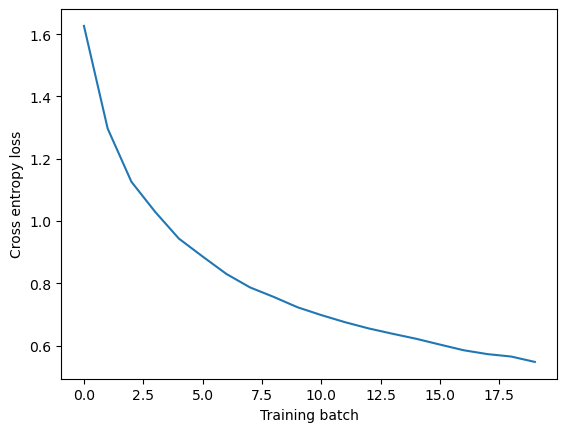

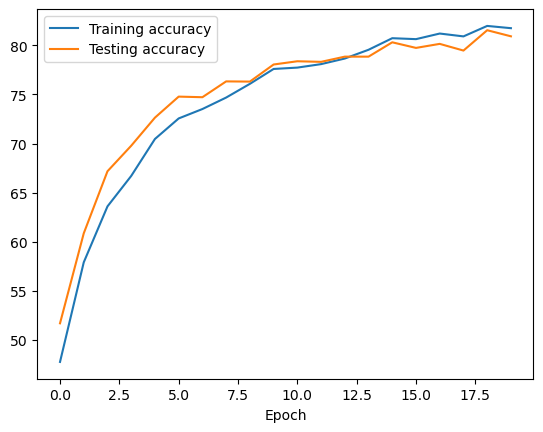

In [13]:
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

losses = [] # Stores the loss for each training batch
train_accs = [] # Stores the training accuracy after each epoch
test_accs = [] # Stores the testing accuracy after each epoch

num_epochs = 20
for epoch in range(num_epochs):
    total_loss=0
    correct_cnt=0
    
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    start_time = time.perf_counter()
    
    model.train()
    
    for images, labels in train_iter:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        predict = model(images)
        l = criterion(predict, labels)
        l.backward()
        optimizer.step()
        total_loss += l.item() *images.shape[0]

    loss = round(total_loss / len(train_iter.dataset), 4)
    losses.append(loss)

    
    with torch.no_grad(): # Computing performance metrics does not require gradients
        model.eval()
        train_accs.append(evaluate_metric(model, train_iter, correct))
        test_accs.append(evaluate_metric(model, test_iter, correct)) #compute accuracy in the testing dataset

        end_time = time.perf_counter()
        print(f'Loss:{loss} Training accuracy: {train_accs[-1]:.2f}%. Testing accuracy: {test_accs[-1]:.2f}%. Duration: {end_time - start_time:.3f}s.') # Computes and displays training/testing dataset accuracy.



plt.plot(losses) # Plots the loss for each training batch
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()


plt.plot(train_accs, label='Training accuracy')
plt.plot(test_accs, label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()

# confusion matrix

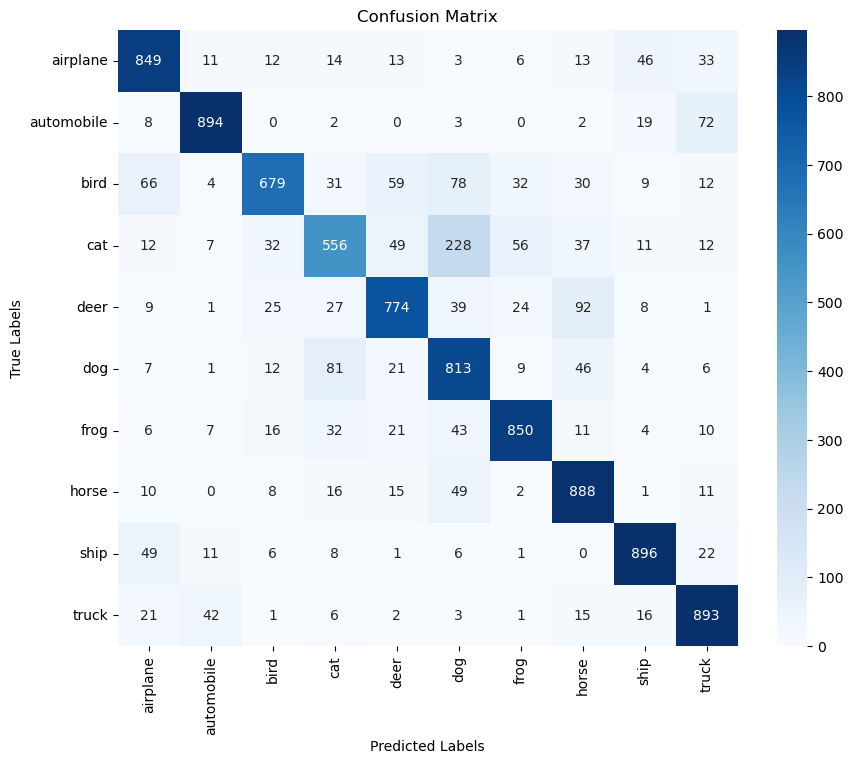

In [14]:
classes = train_dataset.classes
all_preds = []
all_labels = []

with torch.no_grad():
    model.eval()
    for images, labels in test_iter:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [15]:
def imshow(images, labels, predicted):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 3))
    for i, (img, label, pred) in enumerate(zip(images, labels, predicted)):
        img = img / 2 + 0.5
        npimg = img.cpu().numpy()
        axs[i].imshow(np.transpose(npimg, (1, 2, 0)))
        axs[i].set_title(f'True: {classes[label]}\nPredicted: {classes[pred]}')
        axs[i].axis('off')
    plt.show()

correct_images, correct_labels, correct_predicted = [], [], []
incorrect_images, incorrect_labels, incorrect_predicted = [], [], []

with torch.no_grad():
    model.eval()
    for images, labels in test_iter:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        for img, label, pred in zip(images, labels, predicted):
            if pred == label and len(correct_images) < 5:
                correct_images.append(img)
                correct_labels.append(label.item())
                correct_predicted.append(pred.item())
            elif pred != label and len(incorrect_images) < 5:
                incorrect_images.append(img)
                incorrect_labels.append(label.item())
                incorrect_predicted.append(pred.item())
            if len(correct_images) >= 5 and len(incorrect_images) >= 5:
                break
        if len(correct_images) >= 5 and len(incorrect_images) >= 5:
            break


# Image examples of success cases

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Correctly Classified Images


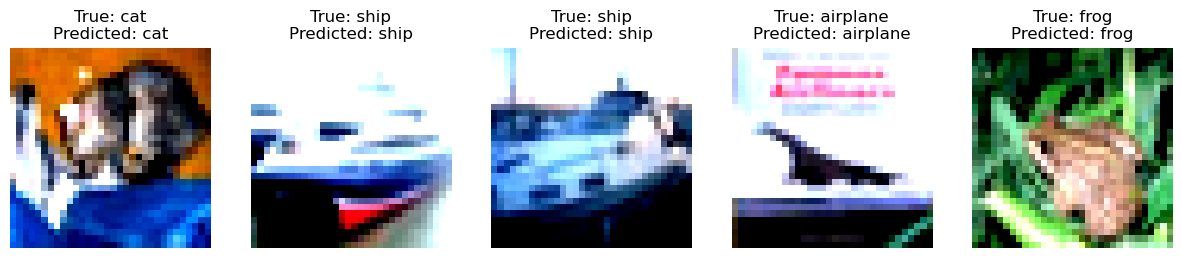

In [16]:
print('Correctly Classified Images')

if len(correct_images) >= 5:
    imshow(correct_images, correct_labels, correct_predicted)

# Image examples of failure cases

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Incorrectly Classified Images


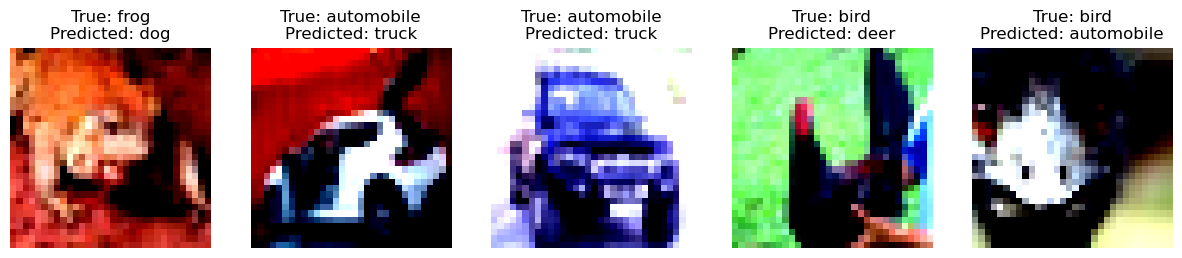

In [17]:
print("Incorrectly Classified Images")

if len(incorrect_images) >= 5:
    imshow(incorrect_images, incorrect_labels, incorrect_predicted)